In [1]:
#General notes
#Total runtime per JJA year of data: 13 min
#Requires External Drive CB1_Data

In [2]:
#Import packages
import sys
import numpy as np
import numba as nb
import time
import netCDF4 as nc
import numpy.ma as ma
import datetime
import os
from netCDF4 import Dataset,num2date,date2num
import matplotlib.pyplot as plt
import math
import thermofeel
import thermofeel.thermofeel as tfc

In [3]:
for y in range(2020,2021):
    for m in range(6,7):

        #0. Read data
        #Runtime: 1 sec
        ds = nc.Dataset('/Volumes/CB1_Data/ERA5_WRFauxiliary/era5_singlelevelformrt_abudhabi_'+str(y)+'0'+str(m)+'.nc');
        fdir=ma.getdata(ds.variables['fdir'][:],subok=False); #total-sky direct solar radiation
        ssr=ma.getdata(ds.variables['ssr'][:],subok=False); #surface net solar radiation
        ssrd=ma.getdata(ds.variables['ssrd'][:],subok=False); #surface solar radiation downwards
        strr=ma.getdata(ds.variables['str'][:],subok=False); #surface net thermal radiation
        strd=ma.getdata(ds.variables['strd'][:],subok=False); #surface thermal radiation downwards
        hourssince=ma.getdata(ds.variables['time'][:],subok=False); #hours since 1900/01/01 00:00 UTC
        ds.close();

        ds = nc.Dataset('/Volumes/CB1_Data/ERA5_WRFauxiliary/era5_singlelevel_abudhabi_'+str(y)+'0'+str(m)+'.nc');
        d2m=ma.getdata(ds.variables['d2m'][:],subok=False); #2m dewpoint temperature (K)
        t2m=ma.getdata(ds.variables['t2m'][:],subok=False); #2m temperature (K)
        u10=ma.getdata(ds.variables['u10'][:],subok=False); #10m u wind (m/s)
        v10=ma.getdata(ds.variables['v10'][:],subok=False); #10m v wind (m/s)
        va=np.sqrt(u10**2+v10**2); #10m wind speed (m/s)
        latitude=ma.getdata(ds.variables['latitude'][:],subok=False); #latitude
        longitude=ma.getdata(ds.variables['longitude'][:],subok=False); #longitude
        ds.close();
        
       
    
        #1. Convert Td (C) to vapor pressure (hPa)
        #WITH NEW VERSION OF THERMOFEEL, THIS IS NO LONGER NEEDED
        #Runtime: 15 sec
        #d2m_c=d2m-273.15;

        #vp=np.zeros((np.size(d2m,axis=0),np.size(d2m,axis=1),np.size(d2m,axis=2)));

        #for dim1 in range(0,np.size(d2m,axis=0)):
        #    for dim2 in range(0,np.size(d2m,axis=1)):
        #        for dim3 in range(0,np.size(d2m,axis=2)):
        #            thisd2m=d2m_c[dim1,dim2,dim3];
        #            if thisd2m>0:
        #                vp[dim1,dim2,dim3]=np.exp(34.494-(4924.99/(thisd2m+237.1)))/((thisd2m+105)**1.57);
        #            else:
        #                vp[dim1,dim2,dim3]=np.exp(43.494-(6545.8/(thisd2m+278)))/((thisd2m+868)**2);

        #vp=vp/100; #convert to hPa
        
        
        
        #2. Convert undifferentiated time array [hours since 1900-01-01 00:00 UTC] to year, month, day, and hour
        #Runtime: 1 sec
        dayssince=hourssince/24;
        yeararr=np.zeros(len(dayssince));
        doyarr=np.zeros(len(dayssince));
        montharr=np.zeros(len(dayssince));
        domarr=np.zeros(len(dayssince));
        hourarr=np.zeros(len(dayssince));

        for i in range(0,len(dayssince+1)): #all days in this file
            yeararr[i]=int(math.floor(dayssince[i]/365.3)+1900)

            #Compute number of leap years in this section of interest
            #Assumes date is in JJA, so Feb 29 would have already happened
            daysum=365; #start with 1900
            for yr in range(1901,int(yeararr[i])): #through Dec 31 of preceding year
                ylen=365;
                if yr%4==0:
                    ylen=366;
                daysum=daysum+ylen;

            doyarr[i]=math.floor(dayssince[i]-daysum+1); #the actual DOY -- so the doy ordinate would be one less
            hourarr[i]=round((dayssince[i]%1)*24); #hours of day run 0-23

            #Convert from DOY to month and day of month
            if yeararr[i]%4==0: #leap year
                adj=1;
            else:
                adj=0;

            if doyarr[i]<=31:
                montharr[i]=1;domarr[i]=doyarr[i];
            elif doyarr[i]<=59+adj:
                montharr[i]=2;domarr[i]=doyarr[i]-31;
            elif doyarr[i]<=90+adj:
                montharr[i]=3;domarr[i]=doyarr[i]-(59+adj);
            elif doyarr[i]<=120+adj:
                montharr[i]=4;domarr[i]=doyarr[i]-(90+adj);
            elif doyarr[i]<=151+adj:
                montharr[i]=5;domarr[i]=doyarr[i]-(120+adj);
            elif doyarr[i]<=181+adj:
                montharr[i]=6;domarr[i]=doyarr[i]-(151+adj);
            elif doyarr[i]<=212+adj:
                montharr[i]=7;domarr[i]=doyarr[i]-(181+adj);
            elif doyarr[i]<=243+adj:
                montharr[i]=8;domarr[i]=doyarr[i]-(212+adj);
            elif doyarr[i]<=273+adj:
                montharr[i]=9;domarr[i]=doyarr[i]-(243+adj);
            elif doyarr[i]<=304+adj:
                montharr[i]=10;domarr[i]=doyarr[i]-(273+adj);
            elif doyarr[i]<=334+adj:
                montharr[i]=11;domarr[i]=doyarr[i]-(304+adj);
            else:
                montharr[i]=12;domarr[i]=doyarr[i]-(334+adj);
                
                
                
        #3. Calculate cossza
        #Runtime: 2 min
        cossza=np.zeros((len(yeararr),len(latitude),len(longitude)));

        for latord in range(0,len(latitude)): 
            for lonord in range(0,len(longitude)):
                thislat=latitude[latord];
                thislon=longitude[lonord];

                for timeord in range(0,len(yeararr)): #hours in month of data obtained
                    thisyear=yeararr[timeord];
                    thismonth=montharr[timeord];
                    thisdom=domarr[timeord];
                    thishour=hourarr[timeord];

                    cossza[timeord,latord,lonord]=tfc.calculate_cos_solar_zenith_angle(thishour,thislat,thislon,thisyear,thismonth,thisdom);
                    
                    
                    
        #4. Calculate MRT (K)
        #Runtime: 2 sec
        #Relevant paper: https://link.springer.com/article/10.1007/s00484-020-01900-5
        dsrp=tfc.approximate_dsrp(fdir,cossza);
        mrt=tfc.calculate_mean_radiant_temperature(ssrd/3600,ssr/3600,dsrp/3600,strd/3600,fdir/3600,strr/3600,cossza);
        
        
        
        #5. Calculate UTCI (C)
        #Runtime: 3 sec
        utci=tfc.calculate_utci(t2m,va,mrt,d2m,None)-273.15;
        
        
        
        #6. Calculate WBGT (C)
        wbgt=tfc.calculate_wbgt(t2m,mrt,va,d2m)-273.15;
        
        
        
        #Save, etc
        try: ncfile.close()
        except: pass

        #Include geographic information about where these values belong
        lonvec=np.linspace(np.min(longitude),np.max(longitude),len(longitude))
        latvec=np.flip(np.linspace(np.min(latitude),np.max(latitude),len(latitude)))

        yeardummy=1;monthdummy=1;daydummy=1;datesout=[None]*len(yeararr);
        for i in range(0,len(yeararr)):
            datesout[i]=datetime.datetime(yeardummy,monthdummy,daydummy,0,0);
            daydummy=daydummy+1;
            if daydummy>=29:
                monthdummy=monthdummy+1;daydummy=1;
            if monthdummy>=13:
                yeardummy=yeardummy+1;monthdummy=1;

        ncfile = nc.Dataset('/Volumes/CB1_Data/ERA5_WRFauxiliary/utciwbgtoutput_abudhabi_'+str(y)+'0'+str(m)+'.nc','w','NETCDF4');

        lat_dim = ncfile.createDimension('lat', len(latitude))
        lon_dim = ncfile.createDimension('lon', len(longitude))
        time_dim = ncfile.createDimension('time', len(yeararr))

        latvar = ncfile.createVariable('lat','float32', ('lat'));latvar[:] = latvec;
        lonvar = ncfile.createVariable('lon','float32', ('lon'));lonvar[:] = lonvec;
        timevar = ncfile.createVariable('time','float64', ('time'));
        unout = 'days since 2000-01-01 00:00:00';
        time.units = 'months';time.long_name = 'time';
        timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);

        myvar=ncfile.createVariable('utci2m','float64',('time','lat','lon'));
        myvar.setncattr('units','C');myvar[:]=utci;
        myvar=ncfile.createVariable('wbgt2m','float64',('time','lat','lon'));
        myvar.setncattr('units','C');myvar[:]=wbgt;
        
        ncfile.close();
        
        print(y);print(m);

2020
6


In [44]:
#Space for checking & troubleshooting
#plt.imshow(fdir[108,:,:]);plt.colorbar()
np.corrcoef(strr.flatten(),strd.flatten())[0,1]

0.25450513342459197

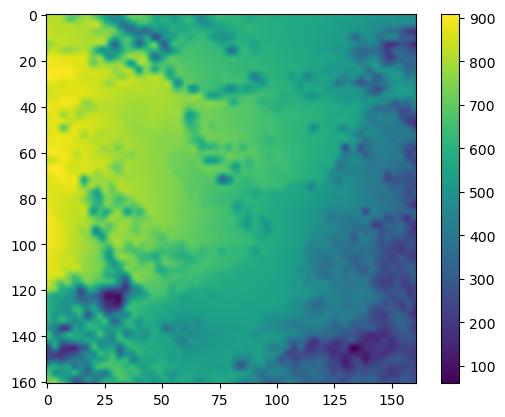

In [60]:

plt.imshow(ssrd[108,:,:]/3600);plt.colorbar()

In [6]:
#If needed, check against results of older version
#import thermofeel.thermofeel as tfc
#mrt2=tfc.calculate_mean_radiant_temperature_OLD(ssrd/3600,ssr/3600,fdir/3600,strd/3600,strr/3600,cossza);
#plt.imshow(mrt2[10,:,:]-273.15);plt.colorbar()